# Intro
In order to use this package while it is in development, the script must be inside the package. This may remain in the final as an example of use.
This package is developed in order to automate segmentation defects in fatigue fracture surfaces. Others have found great success using the Unet architecture, so an implimentation supporting an numbe rof input and output classes was developed. Multiple imput classes are supported so that height map data can be appended to the image data for improved characterization, and multiple output classes are supported so that multiple defect classes can be supported. 

# Forming Dataframe

## EP05+EP07 - DataFrame

In [1]:
import pandas as pd
EP05 = pd.read_excel('/home/aml334/CSE_MSE_RXF131/staging/mds3/fractography/EP05/EP05 Fractographical Data_cycles_added.xlsx')
print(EP05.columns)
print(EP05.head(3))

Index(['Sample#', 'Type', 'a (mm)', 'a/b (b=5mm)', 'σ (Mpa)',
       'F (Empirical formula)', 'Kc (MPa√m)', 'Cycles'],
      dtype='object')
      Sample#     Type    a (mm)  a/b (b=5mm) σ (Mpa)  F (Empirical formula)  \
0  EP05-V31-1  Keyhole  1.573034     0.314607     900               1.136909   
1  EP05-V31-2  Keyhole  1.259740     0.251948     900               1.081787   
2  EP05-V32-1  Keyhole  2.445783     0.489157     667               1.461674   

   Kc (MPa√m)    Cycles  
0   71.930330   56710.0  
1   61.249117   40049.0  
2   85.459481  228510.0  


In [2]:
EP07 = pd.read_excel('/home/aml334/CSE_MSE_RXF131/staging/mds3/fractography/EP07/EP07-Fractographical Data.xlsx')
print(EP07.columns)
print(EP07.head(3))

Index(['Sample#', 'Type', 'a (mm)', 'a/b (b=5mm)', 'σ (Mpa)',
       'F (Empirical formula)', 'Kc (MPa√m)'],
      dtype='object')
      Sample#     Type    a (mm) a/b (b=5mm)  σ (Mpa) F (Empirical formula)  \
0  EP07-V31-1  Keyhole  1.056872    0.211374    667.0              1.057993   
1  EP07-V31-2  Keyhole  1.916517    0.383303    533.0              1.227906   
2  EP07-V32-1  Keyhole  1.545455    0.309091    667.0              1.131095   

  Kc (MPa√m)  
0  40.662573  
1  50.783612  
2  52.568794  


In [3]:
initation_sites = pd.read_csv('/mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractography/raw_initiation_only.csv')

## Matching Processing Conditions

In [4]:
process_parameters = pd.read_csv('/home/aml334/CSE_MSE_RXF131/staging/mds3/fractography/variable-process-parameters.csv')
print(process_parameters)

  Test ID  Process Regime  P (W)  V (mm/s)
0     PV2         Keyhole    370       600
1     PV3         Keyhole    370       800
2     PV4  Process Window    330      1585
3     PV5  Process Window    370      1800
4     PV6  Process Window    370      1400
5     PV7             LOF    150      1200
6     PV8             LOF    370      3000
7     PV9             LOF    370      2000
8     PVE  Process Window    280      1200


In [5]:
def name_to_power(name:str, position:int):
    for idx, option in enumerate(process_parameters['Test ID']):
        if(option[2] == name[position]):
            return process_parameters['P (W)'][idx]
def name_to_velocity(name:str,position:int):
    for idx, option in enumerate(process_parameters['Test ID']):
        if(option[2] == name[position]):
            return process_parameters['V (mm/s)'][idx]
print(name_to_power(str(4),0))
print(name_to_velocity(str(2),0))

330
600


In [6]:
output = pd.concat([EP05,EP07])[['Sample#','Cycles','σ (Mpa)']]

output['Load Ratio (R)'] = 0.1
output['Power (W)'] = output['Sample#'].apply(lambda row:name_to_power(row,6))
output['Velocity (mm/s)'] = output['Sample#'].apply(lambda row: name_to_velocity(row,6))
output.head(3)

,Sample#,Cycles,σ (Mpa),Load Ratio (R),Power (W),Velocity (mm/s)
0,EP05-V31-1,56710.0,900,0.1,370,800
1,EP05-V31-2,40049.0,900,0.1,370,800
2,EP05-V32-1,228510.0,667,0.1,370,800


In [7]:
images = pd.read_csv('/home/aml334/CSE_MSE_RXF131/staging/mds3/fractography/rawdata.csv')
images = images[images['entry']=='stitch']
images.rename(columns={'raw_name':'stitched_img_path'},inplace=True) 
images['Sample#'] = images['raw_basename'].str[:-13]
#print(images.head(3))
#print(images['raw_basename'])
results = pd.merge(output,images,on='Sample#')
print(results)
print(results.columns)
print(len(results))
results.to_csv('/home/aml334/CSE_MSE_RXF131/staging/mds3/fractography/schema_data.csv')
# i = results['σ (Mpa)'].idxmin()
# print(results['Sample#'][i])
# print(results['σ (Mpa)'][i])
# print(results['Cycles'][i])

       Sample#     Cycles σ (Mpa)  Load Ratio (R)  Power (W)  Velocity (mm/s)  \
0   EP05-V31-1    56710.0     900             0.1        370              800   
1   EP05-V31-2    40049.0     900             0.1        370              800   
2   EP05-V32-1   228510.0     667             0.1        370              800   
3   EP05-V32-2    89920.0     667             0.1        370              800   
4   EP05-V33-2    46231.0     533             0.1        370              800   
5   EP05-V41-1    33175.0    1067             0.1        330             1585   
6   EP05-V42-1    50292.0     900             0.1        330             1585   
7   EP05-V42-2    76046.0     900             0.1        330             1585   
8   EP05-V51-1    40232.0    1067             0.1        370             1800   
9   EP05-V51-2    76224.0     900             0.1        370             1800   
10  EP05-V52-2    18964.0    1200             0.1        370             1800   
11  EP05-V64-1  2419759.0   

Now that we have a dataframe, lets see how much redundancy theere is in the dataset.

## Numerical Results (Brett DataFrame)

In [8]:
#Excel to Dataframe
Brett_spreadsheet = pd.ExcelFile('/mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractography/Trial_Brett_7_11_2024.xlsx')
excel_df=pd.DataFrame()
for worksheet in Brett_spreadsheet.sheet_names:
    excel_df = pd.concat([excel_df,pd.read_excel(Brett_spreadsheet,worksheet)])
print(excel_df.columns)

#Filter Based on Cycles
excel_df = excel_df[excel_df['Cycles '].notna()]
type_counts = excel_df['Cycles '].apply(type).value_counts()
print(type_counts)
excel_df = excel_df[excel_df['Cycles '].apply(lambda x: isinstance(x, int) or isinstance(x,float))]
excel_df['Cycles '] = excel_df['Cycles '].astype(int)
type_counts = excel_df['Cycles '].apply(type).value_counts()
print(type_counts)

#Filtering Based on BuildID
excel_df = excel_df[excel_df['Build ID'].notna()]

#Making key
excel_df['Sample#'] = excel_df['Build ID'] + '-'+excel_df['Build #'].astype(str).str.rstrip('.0')+'-'+excel_df['Test #'].astype(str).str.rstrip('.0')

Index(['Build ID', 'Build #', 'Test #', 'Retest', 'Project Name',
       'Cleaning Status', 'Imaging Status', 'Defect Quantification Status',
       'Scan Power (W)', 'Scan velocity (mm/s)', 'b (mm)', 'd (mm)', 'L (mm)',
       'Tested?', 'Date Tested', 'Machine', 'P max (N)', 'P min (N)',
       'R-ratio', 'σ max initiation (MPa)', 'Frequency (Hz)', 'Cycles ',
       'Date Imaged', 'Initiation type', 'Surface or subsurface', 'Notes:',
       'Hatch Spacing (mm)', 'Location:', 'Imaged?', 'Visible Defect?'],
      dtype='object')
Cycles 
<class 'float'>    315
<class 'int'>       38
<class 'str'>        1
Name: count, dtype: int64
Cycles 
<class 'int'>    353
Name: count, dtype: int64


/tmp/job.2076634.hpc/ipykernel_2317533/315560972.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  excel_df = pd.concat([excel_df,pd.read_excel(Brett_spreadsheet,worksheet)])
/tmp/job.2076634.hpc/ipykernel_2317533/315560972.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  excel_df = pd.concat([excel_df,pd.read_excel(Brett_spreadsheet,worksheet)])
/tmp/job.2076634.hpc/ipykernel_2317533/315560972.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depr

excel_df is not a resonably well constructed dsataframe that contains the testing conditions and numerical results for the samples. We can now explore this a bit, and latter merge with the image columns based on the identification columns, to get a more complete dataset.

86
51
   Build ID Build #  Test #  Retest Project Name  Cleaning Status  \
0     CMU01    30.0     1.0     0.0         STRI              NaN   
1     CMU01    30.0     2.0     0.0         STRI              NaN   
24    CMU01    10.0     2.0     0.0          ULI              NaN   
67    CMU01    30.0     1.0     0.0         STRI              NaN   
68    CMU01    30.0     2.0     0.0         STRI              NaN   

    Imaging Status  Defect Quantification Status  Scan Power (W)  \
0              NaN                           NaN           370.0   
1              NaN                           NaN           370.0   
24             NaN                           NaN           370.0   
67             NaN                           NaN           370.0   
68             NaN                           NaN           370.0   

    Scan velocity (mm/s)  ...  Cycles   Date Imaged  Initiation type  \
0                 1000.0  ...  3763500          NaT              NaN   
1                 1000.0  

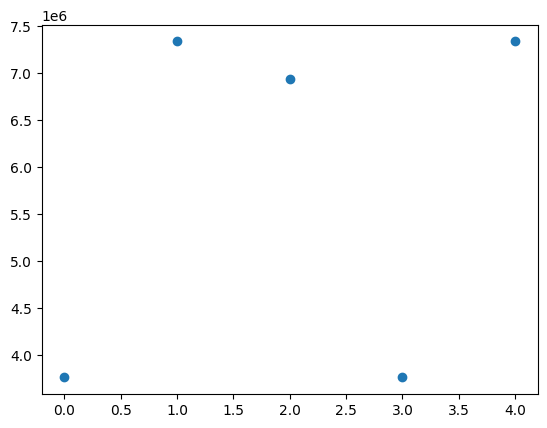

In [9]:
excel_df['R-ratio'].value_counts()
excel_df['Hatch Spacing (mm)'].value_counts()
P_max = excel_df['P max (N)'].value_counts().idxmax()
most_common = excel_df[excel_df['P max (N)']==P_max]
print(len(most_common))
Scan_Power_max = most_common['Scan Power (W)'].value_counts().idxmax()
most_common = most_common[most_common['Scan Power (W)']==Scan_Power_max]
print(len(most_common))
Scan_Velocity_max = most_common['Scan velocity (mm/s)'].value_counts().idxmax()
most_common = most_common[most_common['Scan velocity (mm/s)']==Scan_Velocity_max]
print(most_common)


import matplotlib.pyplot as plt
plt.scatter(range(len(most_common)),most_common['Cycles '])

From the above code, we can see that some of the samples had identical processing and testing conditions, but still varied by more than 3 million cycles, a pretty substantial range.   

In [3]:
print('Total number of tests: '+str(len(excel_df[['P max (N)','Scan velocity (mm/s)','Scan Power (W)']])))
print('Total number of testing conditions: '+str(len(excel_df[['P max (N)','Scan velocity (mm/s)','Scan Power (W)']].drop_duplicates())))

import math
groups = excel_df.groupby(['P max (N)','Scan velocity (mm/s)','Scan Power (W)'])
#When run, the results are largely identical, so the simpler max-min will be used
# max_difference_cycles = []
# for name, group in groups:
#     if(len(group)>2):
#         no_retake = group[group['Retest']==float(0)]
#         try:
#             max_difference_cycles.append(math.log(abs(no_retake['Cycles '].median()-no_retake['Cycles '].mean())+1))
#         except ValueError:
#             print('In group: '+str(name)+' something werid is going on')
# plt.scatter(range(len(max_difference_cycles)),max_difference_cycles)

max_difference_cycles = []
for name, group in groups:
    if(len(group)>2):
        print(group)
        no_retake = group[group['Retest']==float(0)]
        try:
            max_difference_cycles.append(no_retake['Cycles '].max()-no_retake['Cycles '].min())
        except ValueError:
            print('In group: '+str(name)+' something werid is going on')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(max_difference_cycles,bins=50)
ax2.scatter(range(len(max_difference_cycles)),max_difference_cycles)
# ax2.hist([math.log(x+10000000000) for x in max_difference_cycles],bins=50)

NameError: name 'excel_df' is not defined

From the above code, we can see that the some of these testing conditions seem to have a largely bimodal distribution, there are testing conditions with basically 0 variation, and testing conditions with tons and tons of variation. Interestingly, this trend is maintained as the number of samples increase.
Upon further investigations, the samples were not actaully close to 0, log removes any sortof clustering. So all of the samples have actaully quite a lot of variation.

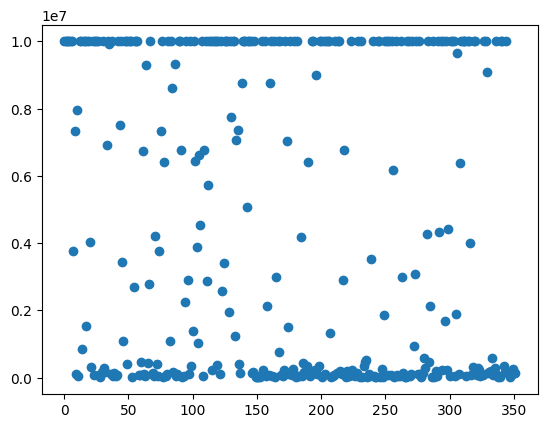

In [11]:
plt.scatter(range(len(excel_df['Cycles '])),excel_df['Cycles '])

The distribution of variation of cycles accross the testing conditions and the graph of all cycles seem to be visually similar.
Lets see if we can correlate differences in cycles within testing conditions to the differences in initiatingdefects.

In [12]:
print(excel_df['Sample#'].value_counts())
Sample_num_max = excel_df['Sample#'].value_counts().idxmax()
excel_df[excel_df['Sample#']==Sample_num_max]

Sample#
CMU01-3-2     5
CMU01-2-2     4
CMU01-4-1     3
CMU01-3-1     3
CMU02-2-1     3
             ..
CMU01-8-2     1
CMU01-9-2     1
CMU01-1-1     1
CMU01-11-2    1
CMU01-12-1    1
Name: count, Length: 287, dtype: int64


,Build ID,Build #,Test #,Retest,Project Name,Cleaning Status,Imaging Status,Defect Quantification Status,Scan Power (W),Scan velocity (mm/s),...,Cycles,Date Imaged,Initiation type,Surface or subsurface,Notes:,Hatch Spacing (mm),Location:,Imaged?,Visible Defect?,Sample#
1,CMU01,30.0,2.0,0.0,STRI,NaN,NaN,NaN,370.0,1000.0,...,7335546,NaT,NaN,NaN,NaN,0.14,NaN,NaN,NaN,CMU01-3-2
6,CMU01,3.0,2.0,0.0,ULI,NaN,NaN,NaN,370.0,1150.0,...,10000000,NaT,NaN,NaN,NaN,0.14,NaN,NaN,NaN,CMU01-3-2
7,CMU01,3.0,2.0,1.0,ULI,NaN,NaN,NaN,370.0,1150.0,...,10000000,NaT,NaN,NaN,NaN,0.14,NaN,NaN,NaN,CMU01-3-2
8,CMU01,3.0,2.0,2.0,ULI,NaN,NaN,NaN,370.0,1150.0,...,1545650,NaT,NaN,NaN,NaN,0.14,NaN,NaN,NaN,CMU01-3-2
68,CMU01,30.0,2.0,0.0,STRI,NaN,NaN,NaN,370.0,1000.0,...,7335546,NaT,NaN,NaN,NaN,0.14,NaN,NaN,NaN,CMU01-3-2


In [13]:
for name, group in excel_df.groupby(['Build ID', 'Build #','Test #']):
    print(str(group[['Retest','Sample#','Cycles ']]))
    # for idex, row in group.iterrows():
    #     if row['Retest']==float(1):
    #         print(group)

   Retest    Sample#  Cycles 
1     0.0  CMU01-1-2  7969454
   Retest    Sample#  Cycles 
2     0.0  CMU01-2-1    49396
   Retest    Sample#   Cycles 
0     1.0  CMU01-2-2  10000000
3     0.0  CMU01-2-2  10000000
4     1.0  CMU01-2-2  10000000
   Retest    Sample#  Cycles 
5     0.0  CMU01-3-1   857305
   Retest    Sample#   Cycles 
6     0.0  CMU01-3-2  10000000
7     1.0  CMU01-3-2  10000000
8     2.0  CMU01-3-2   1545650
    Retest    Sample#   Cycles 
1      1.0  CMU01-4-1  10000000
9      0.0  CMU01-4-1  10000000
10     1.0  CMU01-4-1  10000000
    Retest    Sample#  Cycles 
11     0.0  CMU01-4-2  4036228
    Retest    Sample#  Cycles 
12     0.0  CMU01-5-1   302356
    Retest    Sample#   Cycles 
13     0.0  CMU01-5-2  10000000
14     1.0  CMU01-5-2     71525
    Retest    Sample#   Cycles 
15     0.0  CMU01-6-1  10000000
    Retest    Sample#   Cycles 
16     0.0  CMU01-6-2  10000000
    Retest    Sample#   Cycles 
2      0.0  CMU01-7-1  10000000
17     0.0  CMU01-7-1  10000000


Scrolling through the above code makes it seem like Sample# is sufficent to have almost all of the groups with retakes to have at least 1 other sample.

In [14]:
for name, group in excel_df.groupby(['Sample#']):
    group

## FAIRify Column names
I would like to have the stitched image(stitched or STITCHED), the initiation site(001), the manuel masks for both
We might want to consider the number of runouts in process parameters
We already have classified images, so it might be good to have a CNN, can be used to establish the conditions
We might want to consider the 
See if the centroid of the defects for x and y is within the bounding box of the sample

In [15]:
#Make datasets from the dataframe
# from make_dataset import dataset_setup
# dataset_setup(, supervised_masks, TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT, combined_dataset = False, BATCH_SIZE=5)

## Image Filepaths -> Dictionary Keys

In [16]:
import os
fractography_path = '/mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractography'
manuel_mask_path = '/mnt/vstor/CSE_MSE_RXF131/lab-staging/mds3/keyence-fractography/manuel_mask'
#Adds File if Condition(path) return True
def recursive_search(condition,path:str, file_list:list):
    if os.path.isdir(path):
        for path_loop in os.listdir(path):
            recursive_search(condition,os.path.join(path,path_loop),file_list)
    else:
        if(condition(path)):
            file_list.append(path)
    return file_list

#Definition Different columns that would be valuable to have
def stitched(path):
    if 'stitched' in path.lower():
        return True
    elif'composite' in path.lower():
        return True
    else:
        return False

def exists(path):
    return True 
def png(path):
    if ('.png' in path.lower()):
        return True
    else:
        return False
def marked(path):
    if 'marked' in path.lower():
        return True
    else:
        return False

def initiation(path):
    if '_001' in path:
        return True
    elif 'initiation' in path.lower():
        return True
    else:
        return False
def marked_and_initiation(path):
    if initiation(path) and marked(path):
        return True
    else:
        return False
def marked_and_stitched(path):
    if marked(path) and stitched(path):
        return True
    else:
        return False
def fatigue(path):
    if 'fatigue' in path.lower():
        return True
    else:
        return False
def overload(path):
    if 'overload' in path.lower():
        return True
    else:
        return False
def fatigue_and_png(path):
    if png(path) and fatigue(path):
        return True
    else:
        return False
def stitched_and_png_not_fatigue(path):
    if png(path) and stitched(path) and not fatigue(path):
        return True
    else:
        return False
path_list = [fractography_path,manuel_mask_path]
condition_list = [exists,stitched_and_png_not_fatigue,initiation,marked_and_initiation, marked_and_stitched,fatigue,overload,fatigue_and_png]
name = []
column_dict = {}
i=0
for top_folder in path_list:
    for column in condition_list:
        temp_list = []
        column_dict[column.__name__+'_'+os.path.basename(top_folder)]=recursive_search(
            column,
            top_folder,
            temp_list
        )
        name.append((column.__name__+'_'+os.path.basename(top_folder),len(column_dict[column.__name__+'_'+os.path.basename(top_folder)])))
        print(str(name[i]) +f'\tPosition: {i}')
        i+=1



('exists_fractography', 5256)	Position: 0
('stitched_and_png_not_fatigue_fractography', 27)	Position: 1
('initiation_fractography', 768)	Position: 2
('marked_and_initiation_fractography', 51)	Position: 3
('marked_and_stitched_fractography', 52)	Position: 4
('fatigue_fractography', 0)	Position: 5
('overload_fractography', 2)	Position: 6
('fatigue_and_png_fractography', 0)	Position: 7
('exists_manuel_mask', 397)	Position: 8
('stitched_and_png_not_fatigue_manuel_mask', 164)	Position: 9
('initiation_manuel_mask', 0)	Position: 10
('marked_and_initiation_manuel_mask', 0)	Position: 11
('marked_and_stitched_manuel_mask', 3)	Position: 12
('fatigue_manuel_mask', 112)	Position: 13
('overload_manuel_mask', 112)	Position: 14
('fatigue_and_png_manuel_mask', 56)	Position: 15


## Dictionary Keys -> Pandas DataFrames
Now that we have the paths in a python dictionary, we can convert each key into a a different dataframe, with type and series information available to merge the data frames on.
Here, the regex package is used to identiy the common file name structure. 

In [17]:
import re
check = re.compile(r'''
    ^(EP|NASA|CMU)  # Start with EP, NASA, or CMU (case insensitive)
    [-_]?           # Optional separator
    (\d+|O\d+)      # Number or O followed by number
    .*?             # Any characters in between (non-greedy)
    (?:             # Non-capturing group
        [-_]?V?     # Optional separator and V
        ([E\d]+)       # Version number
        (?:[-_](\d+))?  # Optional additional number
    )?
    .*?             # Any characters in between (non-greedy)
    \.(png|tif)$    # File extension (png or tif)
''', re.VERBOSE | re.IGNORECASE)
def output(pattern):
    match = re.search(check,pattern)
    if(match):
        # print(match.groups())
        # print(match)
        return match.group(1).lower()+match.group(2), match.group(3).lower() ,match.group(4) if match.group(4) else None
    else:
        return None

#Testing Function on Data
# for key in column_dict:
#     for field in column_dict[key]:
#         if not output(field.split('/')[-1]):
#             print(field.split('/')[-1])

            
dataframe_list = []
for i, key in enumerate(column_dict):
    type_column = []
    series_column = []
    posit_idx_column = []
    basename = []
    Sample_num = []
    for j, field in enumerate(column_dict[key]):
        if output(field.split('/')[-1]):
            type_inst, series_inst, posit_idx_inst = output(field.split('/')[-1])
            type_column.append(type_inst)
            series_column.append(series_inst)
            posit_idx_column.append(posit_idx_inst)
            basename.append(field.split('/')[-1])
            if posit_idx_inst == None:
                Sample_num.append(type_inst.upper()+'-'+str(series_inst)+'-1')
            else:
                Sample_num.append(type_inst.upper()+'-'+str(series_inst)+'-'+str(posit_idx_inst))
        else:
            type_inst=None
            series_inst=None
            posit_idx_inst=None
    path_column = pd.Series(column_dict[key],name='path')
    type_column = pd.Series(type_column, name='type')
    series_column = pd.Series(series_column,name='series')
    posit_idx_column = pd.Series(posit_idx_column,name='posit_idx')
    basename_column = pd.Series(basename,name='basename')
    Sample_num_column= pd.Series(Sample_num, name = 'Sample#')
    dataframe_list.append(
        pd.concat(
            [
                Sample_num_column,
                path_column,
                type_column,
                series_column,
                posit_idx_column,
                basename_column,
            ],
            axis=1
        )
    )
    print(str(name[i])+ '\tPosition: '+str(i))
    print(dataframe_list[i].head(7))
    print(dataframe_list[i].columns)


('exists_fractography', 5256)	Position: 0
     Sample#                                               path   type series  \
0  CMU01-1-1  /mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractog...  cmu01      1   
1  CMU01-1-1  /mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractog...  cmu01      1   
2  CMU01-1-1  /mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractog...  cmu01      1   
3  CMU01-1-1  /mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractog...  cmu01      1   
4  CMU01-1-2  /mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractog...  cmu01      1   
5  CMU01-1-2  /mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractog...  cmu01      1   
6  CMU01-1-2  /mnt/vstor/CSE_MSE_RXF131/staging/mds3/fractog...  cmu01      1   

  posit_idx                                 basename  
0         1  CMU01-1-1 INITIATION_001-checkpoint.tif  
1         1             CMU01-1-1 INITIATION_001.tif  
2         1             CMU01-1-1 INITIATION_002.tif  
3         1                   CMU01-1-1 STITCHED.tif  
4         2             CMU01-1-2 

: 

Now that we have build ID in all of the dataframes for the both Brett's dataframe, and the images, we can merge them and try to correlate the variation of the testing and processing conditions with some properties of the defects contained in the images.

In [18]:
import psutil
columns_to_keep = ['Sample#','path']
combined_df = pd.merge(dataframe_list[0][columns_to_keep],dataframe_list[1][columns_to_keep],on='Sample#',suffixes=('_x'+name[0][0],'_'+name[1][0]),how='outer')
i=0
for dataframe in dataframe_list:
    try:
        combined_df = pd.merge(combined_df,dataframe[columns_to_keep],on='Sample#',suffixes=('',f'_{name[i][0]}'),how='outer')
        dataframe.to_csv(f'{i}.csv')
        i+=1
    except Exception as e:
        print(e)
combined_df.to_csv('combined_df_temp.csv')
excel_df.to_csv('excel_df_temp.csv')
combined_df = pd.merge(combined_df,excel_df,on='Sample#')
combined_df.to_csv('combined_df.csv')
row_structure = '|{:^50}|{:^10}|{:^20}|'
print(row_structure.format('Column name', 'Nulls','Position'))
i=0
for column in combined_df.columns:
    print(row_structure.format(column, str(combined_df[column].isna().sum()),str(i)))
    i+=1

Now that we have the files in a dataframe, we can match their titles to processing paramters.

In [ ]:
for i in range(len(dataframe_list)):
    dataframe_list[i]['Power (W)'] = dataframe_list[i].apply(lambda row:name_to_power(row,6))
output['Power (W)'] = output['Sample#'].apply(lambda row:name_to_power(row,6))
output['Velocity (mm/s)'] = output['Sample#'].apply(lambda row: name_to_velocity(row,6))

ValueError: Cannot set a DataFrame with multiple columns to the single column Power (W)

# Train Model on Defects 
Now that we have dataframes, we can begin to train the models by merging them. The easiest region of interest is the fatigue region, so we will begin with that. Histogram matching will be applied to help increase contrast

In [ ]:
# from unet import Unet
# import importlib
# import cv2
# from train_GAN import train_GAN
# from discriminator_loss import discriminator_loss
# from semi_supervised_loss import semi_supervised_loss
# from multiclass_dataset import Multiclass_dataset
# from combined_dataset import combined_dataset
# #importlib.reload(make_dataset)
# from make_dataset import dataset_setup
# import torch
# # Initalize The Dataset
# merge = pd.merge(dataframe_list[-1],dataframe_list[9],on=['type','series','posit_idx'],suffixes=['_mask','_stitched'])
# print(len(merge))
# print(len(dataframe_list[-1]))
# # for i in range(len(merge)):
# #     print(merge['basename_stitched'][i]+str(merge['posit_idx'][i]) +'\t'+str(merge['series'][i])+'\t'+str(merge['type'][i]))
# disunion = dataframe_list[9]['path']
# train_dl, valid_dl = dataset_setup(
#     [merge['path_stitched']],
#     [merge['path_mask']],
#     .80,
#     .15,
#     .05,
# )
# def size_transform(size:[int]):
#     if len(size)!=2:
#         raise ValueError('The size must a list of 2 integers')
#     def apply_transform(Image):
#         return cv2.resize(image,size)

# resize_func = size_transform([512,512])
# unsegmented_raw = Multiclass_dataset(x_unsup=[disunion.dropna()],transform=resize_func)
# # x_unsup is the 
# segmentor = Unet(
#     input_channels = 1,
#     output_channels=1,
# ).to('cuda:0')
# discriminator = Unet(
#     input_channels = 1,
#     output_channels =1,
# ).to('cuda:0')

# train_GAN(
#     discriminator_loss(),
#     torch.nn.BCELoss(),
#     semi_supervised_loss(),
#     segmentor,
#     discriminator,
#     train_dl,
#     valid_dl,
#     unsegmented_raw,
#     2,
#     5,
#     save_path = '/home/aml334/CSE_MSE_RXF131/cradle-members/mds3/aml334'
# )

ModuleNotFoundError: No module named 'unet'

In [ ]:
# from sdlefleets.sdlefleets import run_sdlefleets

# # 5 python jobs
# #Need to add paraquet and estimate duration
# run_sdlefleets(job_name='unet_test_batch',
    # script_path='/home/aml334/CSE_MSE_RXF131/cradle-members/mds3/aml334/mds3-advman/packages/Unet_train/Usage/GAN_script_SDLE_Fleets.py',
    # parquet_path='/home/aml334/CSE_MSE_RXF131/cradle-members/mds3/aml334/GAN_MODELS_1/converted (1).parquet',
    # duration='07:00:00',
    # cpus=4,
    # partition='gpu',
    # ml_lib='-tf',
    # mem=32,
    # )

100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


     Unnamed: 0     Sample# Build ID Build #  Test #  Retest Project Name  \
79          250  CMU14-13-2    CMU14    13.0     2.0     0.0          ULI   
105         256  CMU14-18-1    CMU14    18.0     1.0     0.0         STRI   
114         279   CMU14-4-2    CMU14     4.0     2.0     0.0          ULI   

     Scan Power (W)  Scan velocity (mm/s)  Hatch Spacing (mm)  ...  Mpa  a/b  \
79            280.0                 650.0                0.14  ...  NaN  NaN   
105           280.0                 650.0                0.14  ...  NaN  NaN   
114           280.0                 650.0                0.14  ...  NaN  NaN   

     F(a/b) path_valid_image path_initiation path_stitched  \
79      NaN              NaN             NaN           NaN   
105     NaN              NaN             NaN           NaN   
114     NaN              NaN             NaN           NaN   

     path_full_surface_marked  path_initation_marked_stitched  path_fatigue  \
79                        NaN             

Text(0.5, 0, 'Conditions')

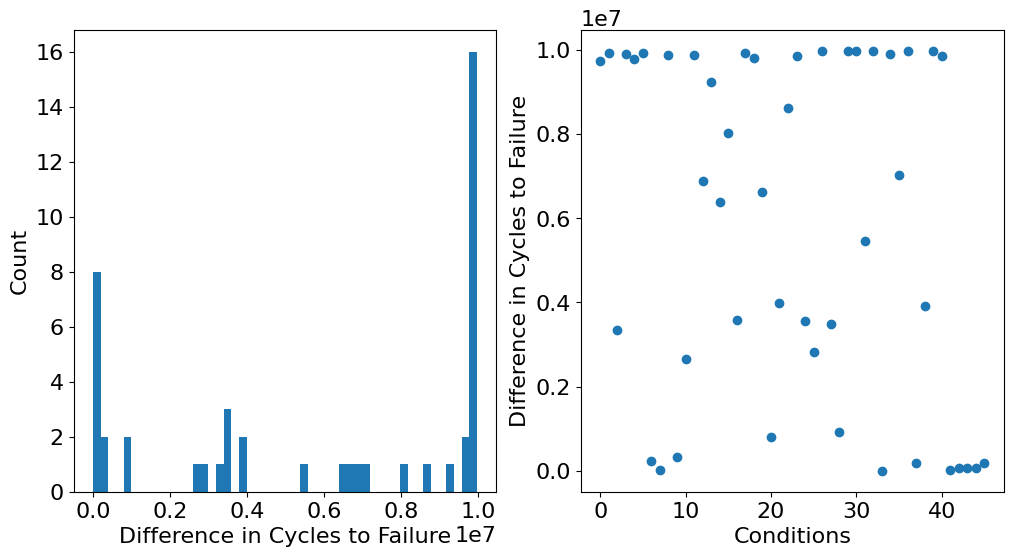

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
combined_df = pd.read_csv('/home/aml334/CSE_MSE_RXF131/lab-staging/mds3/AdvManu/fractography/combined_df.csv')
groups = combined_df.groupby(['Scan velocity (mm/s)','Scan Power (W)','σ max initiation (MPa)'])
max_difference_cycles = []
for name, group in groups:
    if(len(group)>2):
        print(group)
        no_retake = group[group['Retest']==float(0)]
        try:
            max_difference_cycles.append(no_retake['Cycles'].max()-no_retake['Cycles'].min())
        except ValueError:
            print('In group: '+str(name)+' something werid is going on')
plt.rcParams.update({'font.size': 16})  # Set font size for all elements
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(max_difference_cycles,bins=50)
ax1.set_xlabel('Difference in Cycles to Failure')
ax1.set_ylabel('Count')
ax2.scatter(range(len(max_difference_cycles)),max_difference_cycles)
ax2.set_ylabel('Difference in Cycles to Failure')
ax2.set_xlabel('Conditions')